In [1]:
from pathlib import Path
import time
import torch
import numpy as np
import pandas as pd
from dataset import LinearDynamicalDataset, WHDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
#import plotly.graph_objects as go
from transformers_custom_sim import Config, TSTransformer
import tqdm
import argparse

In [2]:
# Overall settings
out_dir = "out"

# System settings
nu = 1
ny = 1
#seq_len = 600
batch_size = 32 # 256
fixed_system = True # Are we testing on a fixed system?
model_seed = None

# Compute settings
cuda_device = "cuda:1"
no_cuda = False
threads = 32
compile = True

# Configure compute
torch.set_num_threads(threads) 
use_cuda = not no_cuda and torch.cuda.is_available()
device_name  = cuda_device if use_cuda else "cpu"
device = torch.device(device_name)
device_type = 'cuda' if 'cuda' in device_name else 'cpu' # for later use in torch.autocast
torch.set_float32_matmul_precision("high")
#torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
#torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn

In [3]:
# Create out dir
out_dir = Path(out_dir)
#exp_data = torch.load(out_dir/"ckpt_lin.pt") # trained on linear models!
#exp_data = torch.load(out_dir/"ckpt_small_wh_last.pt")
#exp_data = torch.load(out_dir/"ckpt_small_wh.pt")
#exp_data = torch.load(out_dir/"ckpt_big.pt", map_location=device)
#exp_data = torch.load(out_dir/"ckpt_small_wh_adapt_last.pt")
exp_data = torch.load(out_dir/"ckpt_encdec_lin_sim.pt")
#exp_data = torch.load(out_dir/"ckpt_encdec_wh.pt")
#exp_data = torch.load(out_dir/"ckpt.pt")
#exp_data = torch.load(out_dir/"ckpt.pt")
cfg = exp_data["cfg"]
# For compatibility with initial experiment without seed
try:
    cfg.seed
except AttributeError:
    cfg.seed = None

In [4]:
seq_len = cfg.seq_len_ctx + cfg.seq_len_new
nx = cfg.nx
model_seed = cfg.seed if model_seed is None else model_seed 

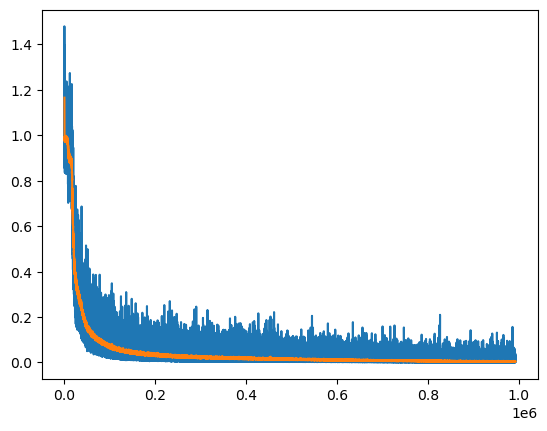

In [5]:
loss_smooth = pd.Series(exp_data["LOSS"]).rolling(100).mean()
#fig = go.Figure()
#fig.add_trace(go.Scatter(y=exp_data["LOSS"], name="TRAINING LOSS", line_color="black"))
#fig.add_trace(go.Scatter(y=loss_smooth, name="TRAINING LOSS SMOOTH", line_color="blue"))
#fig.add_trace(go.Scatter(x=np.arange(1, len(exp_data["LOSS_VAL"])+1)*2000,
#                         y=exp_data["LOSS_VAL"], name="VAL LOSS", line_color="red")
#             )
#fig.show()

plt.figure()
plt.plot(exp_data["LOSS"], label="TRAINING_LOSS")
plt.plot(loss_smooth, label="TRAINING_LOSS_SMOOTH");
#plt.ylim([0, 0.002])

In [6]:
model_args = exp_data["model_args"]
conf = Config(**model_args)
model = TSTransformer(conf).to(device)
model.load_state_dict(exp_data["model"]);

In [7]:
# Create data loader
#test_ds = WHDataset(nx=nx, nu=nu, ny=ny, seq_len=seq_len,
#                    system_seed=cfg.seed if fixed_system else None,
#                    data_seed=None, fixed_system=fixed_system)
test_ds = LinearDynamicalDataset(nx=cfg.nx, nu=cfg.nu, ny=cfg.ny, seq_len=cfg.seq_len_ctx+cfg.seq_len_new)
test_dl = DataLoader(test_ds, batch_size=batch_size, num_workers=threads)

In [8]:
batch_y, batch_u = next(iter(test_dl))
batch_y = batch_y.to(device)
batch_u = batch_u.to(device)
with torch.no_grad():
    batch_y_ctx = batch_y[:, :cfg.seq_len_ctx, :]
    batch_u_ctx = batch_u[:, :cfg.seq_len_ctx, :]
    batch_y_new = batch_y[:, cfg.seq_len_ctx:, :]
    batch_u_new = batch_u[:, cfg.seq_len_ctx:, :]
    batch_y_sim = model(batch_y_ctx, batch_u_ctx, batch_u_new)

In [9]:
batch_y_sim = batch_y_sim.to("cpu").detach().numpy()
batch_y_new = batch_y_new.to("cpu").detach().numpy()
batch_u_new = batch_u_new.to("cpu").detach().numpy()
batch_sim_err = batch_y_new[:, :, :] - batch_y_sim[:, :, :]

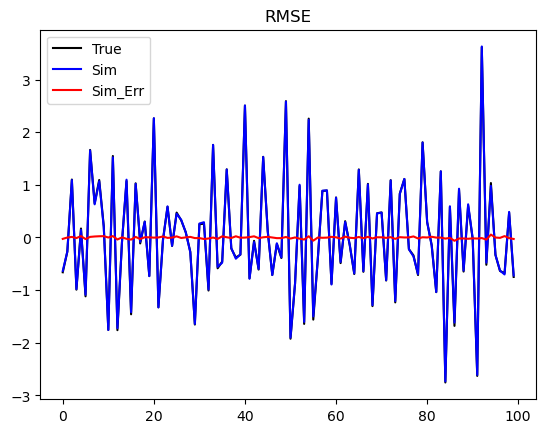

In [18]:
plt.figure()
plt.title("RMSE")
idx = 10
plt.plot(batch_y_new[idx, :, :], 'k', label="True")
#plt.plot(batch_y_pred[idx, :-1, :], 'b', label="Pred")
plt.plot(batch_y_sim[idx, :, :], 'b', label="Sim")
#plt.plot(batch_pred_err[idx, :, :], 'm', label="Pred_Err")
plt.plot(batch_sim_err[idx, :, :], 'r', label="Sim_Err")
plt.legend()

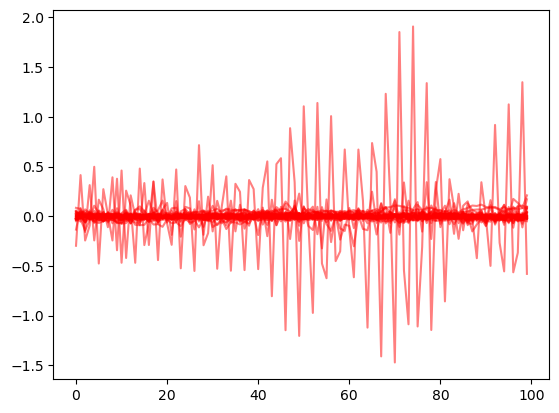

In [11]:
plt.plot(batch_sim_err.squeeze(-1).T, "r", alpha=0.5);
#plt.plot(batch_pred_err.squeeze(-1).T, "m", alpha=0.5);

In [12]:
from torchid import metrics
skip = 0
rmse = metrics.rmse(batch_y_new, batch_y_sim, time_axis=1)

In [13]:
rmse.mean()

0.054411072